In [14]:
import gym
import numpy as np
import random
from collections import defaultdict

In [15]:
env = gym.make('Blackjack-v0')

In [16]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [17]:
# returns action probablities based on epsilon-greedy policy
def probs(Q_s, epsilon, num_actions):
    policy = np.ones(num_actions) * epsilon / num_actions
    best = np.argmax(Q_s)
    policy[best] = 1 - epsilon + (epsilon / num_actions)
    return policy

# generates episode of (state, action, rewared) tuples from policy
def gen_episode(env, Q, epsilon, num_actions):
    episode = []
    state = env.reset()
    while True:
        if state in Q:
            action = np.random.choice(np.arange(num_actions), p=probs(Q[state], epsilon, num_actions))
        else:
            action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = new_state
        if done:
            break
    return episode

# updates Q values based on MC sampling from most recent episode
def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q
    
    

In [18]:
# MC control from episode sampling
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.0):
    num_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(num_actions))
    epsilon = eps_start
    for i in range(1, num_episodes +1):
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = gen_episode(env, Q, epsilon, num_actions)
        Q = update_Q(env, episode, Q, alpha, gamma)
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    return policy, Q


In [19]:
# plotting stuff from github
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()
    
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

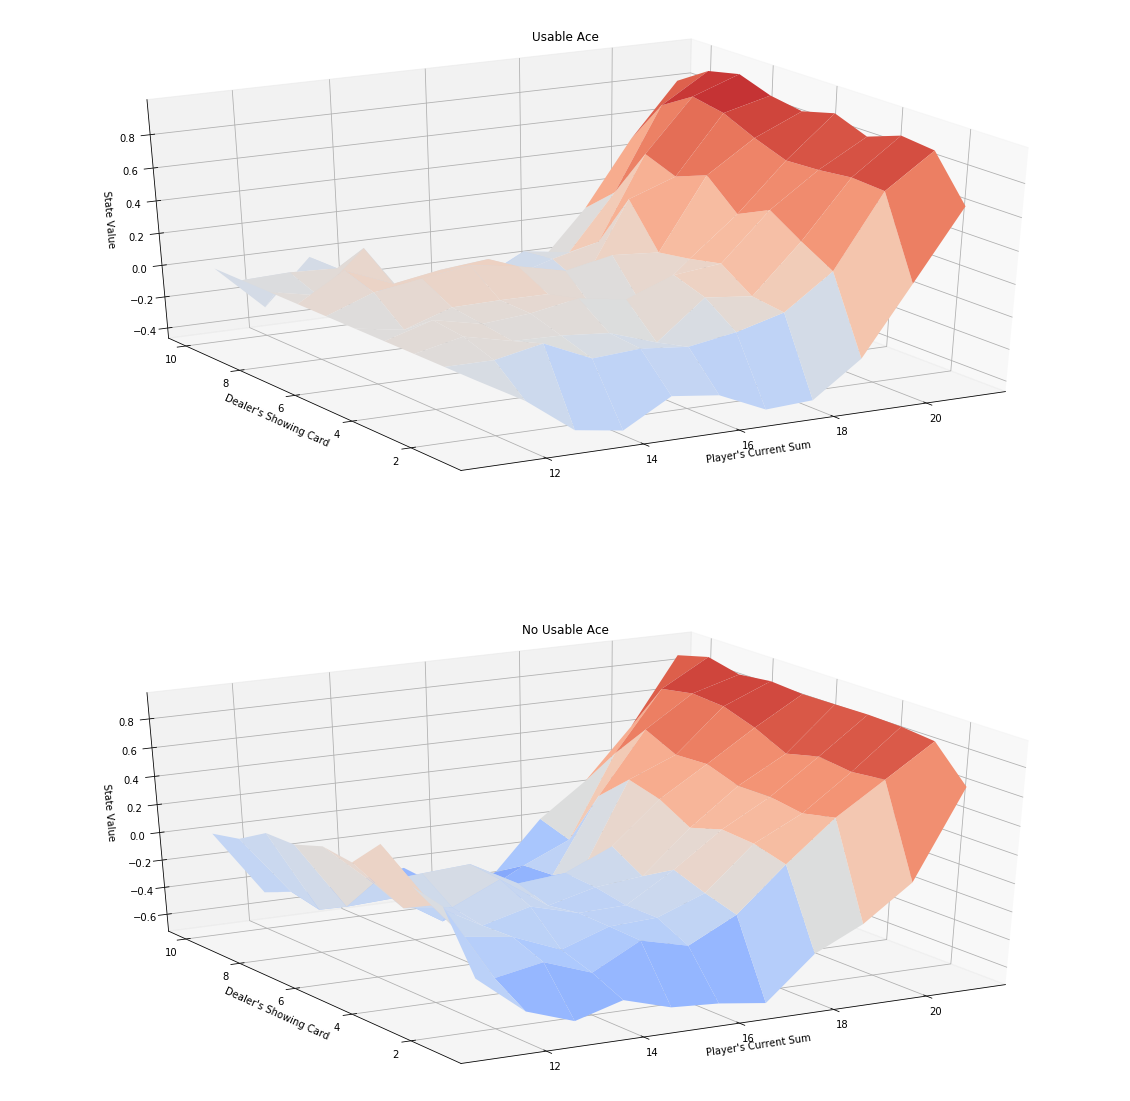

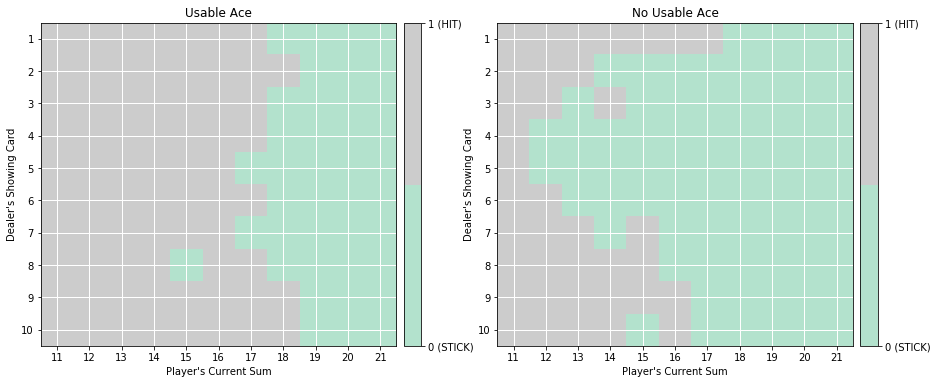

In [20]:
policy, Q = mc_control(env, 500000, 0.015)
V = dict((k,np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)
plot_policy(policy)

In [21]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    current = Q[state][action]
    if state is not None:
        Q_next = Q[state][action]
    else:
        Q_next = 0
    target = reward + (gamma * Q_next) 
    new_value = current + (alpha * (target - current))
    return new_value

def epsilon_greedy(Q, state, num_actions, epsilon):
    if random.random() > epsilon: 
        return np.argmax(Q[state])
    else:                     
        return random.choice(np.arange(env.action_space.n))

In [22]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    num_actions = env.action_space.n               
    Q = defaultdict(lambda: np.zeros(num_actions))  
   
    for i_episode in range(1, num_episodes+1): 
        score = 0                                             
        state = env.reset()                                   
        eps = max(1.0 / i_episode, epsmin)                                 
        action = epsilon_greedy(Q, state, num_actions, eps)            
        
        while True:
            next_state, reward, done, info = env.step(action) 
            score += reward                                   
            if not done:
                next_action = epsilon_greedy(Q, next_state, num_actions, eps) 
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, 
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     
                action = next_action   
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward)
                break
                
    return Q

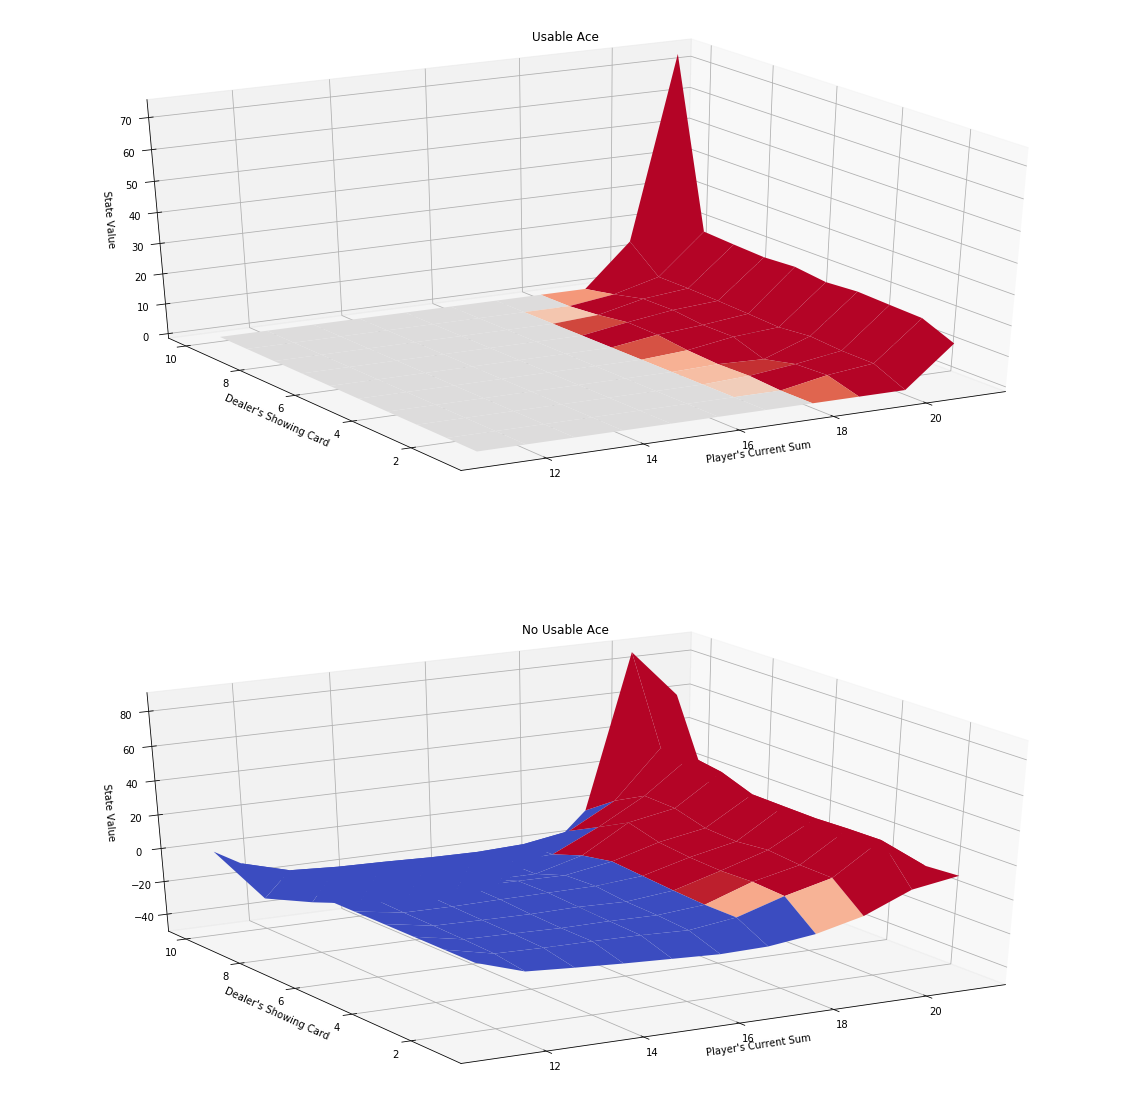

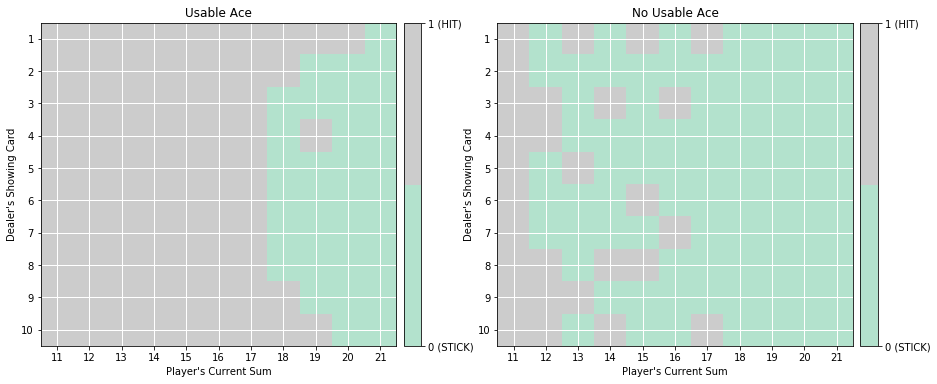

In [23]:
Q_sarsa = sarsa(env, 500000, 0.009)
V = dict((k,np.max(v)) for k, v in Q_sarsa.items())
policy_sarsa = dict((k,np.argmax(v)) for k, v in Q_sarsa.items())

plot_blackjack_values(V)
plot_policy(policy_sarsa)